# Clustering basado en densidades

Los algoritmos de agrupación en clústeres basados en la densidad asignan la pertenencia al clúster en función de la proximidad a otros miembros del clúster. Persiguen el objetivo de identificar regiones densas de formas y tamaños arbitrarios. No requieren la especificación de un cierto número de conglomerados, sino que se basan en parámetros que definen el tamaño de un vecindario y un umbral de densidad.

# Dependencias y configuración

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from time import sleep
from random import shuffle

import numpy as np
from numpy import atleast_2d
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm
import matplotlib.ticker as ticker
import seaborn as sns

from IPython import display

In [2]:
cmap = cm.get_cmap('viridis')
cmap = ListedColormap(sns.xkcd_palette(['denim blue', 
                                        'medium green', 
                                        'pale red']))

## Ejemplo para entender DBSCAN con los datos Iris

In [3]:
iris = load_iris()
print(iris.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])


In [4]:
cmap = cm.get_cmap('viridis')
cmap = ListedColormap(sns.xkcd_palette(['denim blue', 'medium green', 'pale red']))

# Crear un data frame

In [5]:
features = iris.feature_names
data = pd.DataFrame(data=np.column_stack([iris.data, 
                                          iris.target]), 
                    columns=features + ['label'])
data.label = data.label.astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   label              150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


# Estandarizar los datos 

In [6]:
scaler = StandardScaler()
features_standardized = scaler.fit_transform(data[features])
n = len(data)

# Reducir la dimensión para visualizar los grupos

In [7]:
pca = PCA(n_components=2)
features_2D = pca.fit_transform(features_standardized)

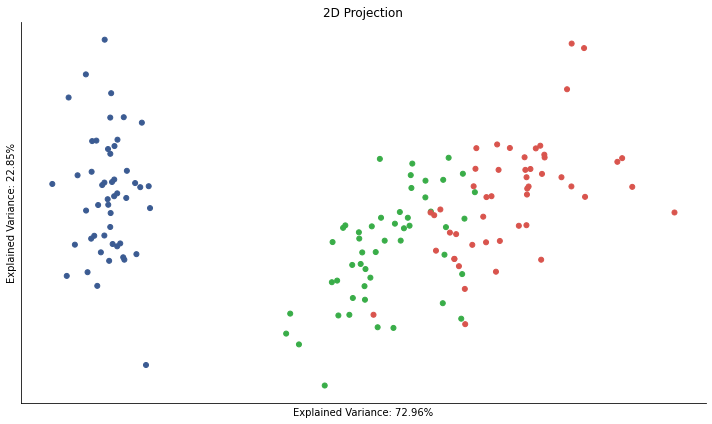

In [8]:
ev1, ev2 = pca.explained_variance_ratio_
ax = plt.figure(figsize=(10, 6)).gca(title='2D Projection', 
                      xlabel=f'Explained Variance: {ev1:.2%}', 
                      ylabel=f'Explained Variance: {ev2:.2%}')
ax.scatter(*features_2D.T, c=data.label, s=25, cmap=cmap)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_yticks([])
sns.despine()
plt.tight_layout();

# Perform DBSCAN clustering

Density-based spatial clustering of applications with noise (DBSCAN) se desarrolló en 1996.

Su objetivo es identificar muestras centrales y no centrales, donde las primeras extienden un clúster y las segundas son parte de un clúster pero no tienen suficientes vecinos cercanos para hacer crecer aún más el clúster. Otras muestras son valores atípicos y no se asignan a ningún grupo.

Utiliza un parámetro eps para el radio de la vecindad y min_samples para el número de miembros necesarios para las muestras del núcleo. Es determinista y exclusivo y tiene dificultades con grupos de diferente densidad y datos de alta dimensión.

[Más información](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html)

 1    71
 0    45
-1    34
Name: clusters, dtype: int64


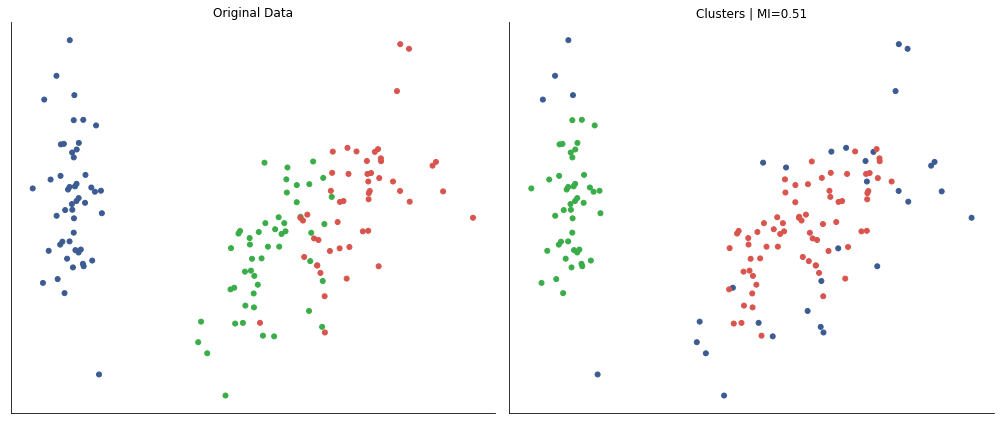

In [9]:
clusterer = DBSCAN() # los parámetros del algoritmo por defecto son:
# DBSCAN(
#     eps=0.5,
#     *,
#     min_samples=5,
#     metric='euclidean',
#     metric_params=None,
#     algorithm='auto',
#     leaf_size=30,
#     p=None,
#     n_jobs=None,
# )

data['clusters'] = clusterer.fit_predict(features_standardized)
print(data['clusters'].value_counts())
fig, axes = plt.subplots(ncols=2, 
                         figsize=(14, 6))

labels, clusters = data.label, data.clusters
mi = adjusted_mutual_info_score(labels, clusters)# mide lo que se parecen las dos columnas
# labels son los tipos de flor y clusters los obtenidos por el método DBSCAN

axes[0].scatter(*features_2D.T, c=data.label, s=25, cmap=cmap)
axes[0].set_title('Original Data')
axes[1].scatter(*features_2D.T, c=data.clusters, s=25, cmap=cmap)
# axes[1].set_title('Clustering data')
axes[1].set_title('Clusters | MI={:.2f}'.format(mi))

for ax in axes:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
sns.despine()
fig.tight_layout()

In [10]:
adjusted_mutual_info_score(labels, labels)

1.0

# Comparación de parámetros de configuración

In [11]:
eps_range = np.arange(.2, .91, .05)
min_samples_range = list(range(3, 10))
labels = data.label
mi = {}
for eps in eps_range:
    for min_samples in min_samples_range:
        clusterer = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = clusterer.fit_predict(features_standardized) 
        mi[(eps, min_samples)] = adjusted_mutual_info_score(clusters, labels)

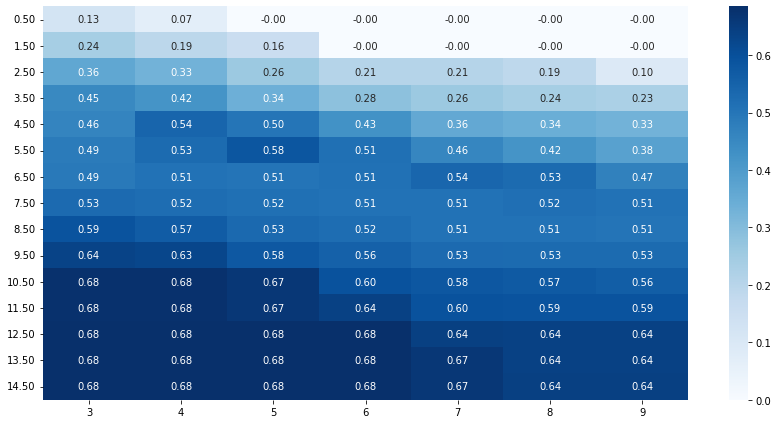

In [12]:
results = pd.Series(mi)
results.index = pd.MultiIndex.from_tuples(results.index)
fig, axes = plt.subplots(figsize=(12, 6))
ax = sns.heatmap(results.unstack(),
                 annot=True,
                 fmt='.2f',
                 cmap='Blues')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
plt.tight_layout()

# Ejecutar otra vez

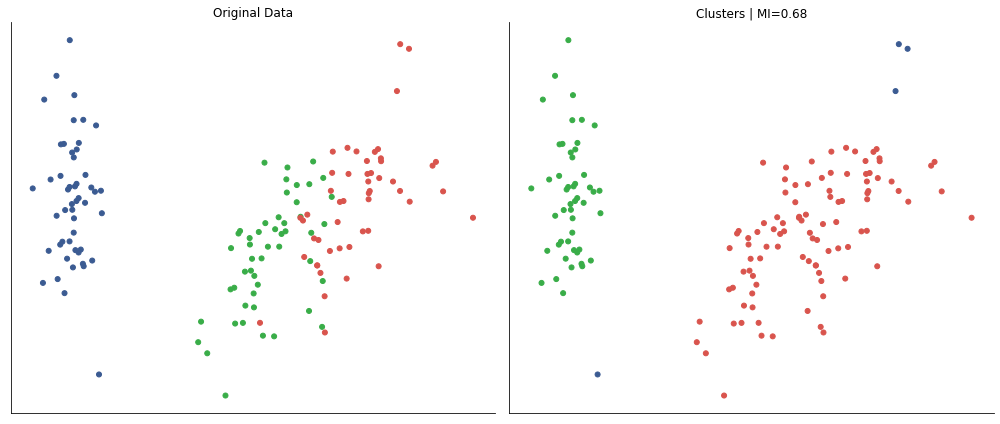

In [13]:
clusterer = DBSCAN(eps=.8, min_samples=5)
data['clusters'] = clusterer.fit_predict(features_standardized)

labels, clusters = data.label, data.clusters
mi = adjusted_mutual_info_score(labels, clusters)

fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
axes[0].scatter(*features_2D.T, c=data.label, s=25, cmap=cmap)
axes[0].set_title('Original Data')
axes[1].scatter(*features_2D.T, c=data.clusters, s=25, cmap=cmap)
axes[1].set_title('Clusters | MI={:.2f}'.format(mi))

for ax in axes:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
sns.despine()
plt.tight_layout()

# Kmeans

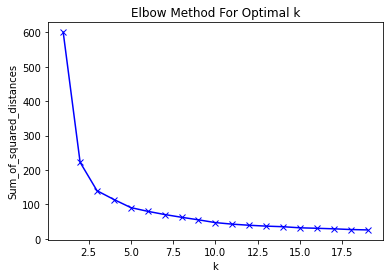

In [14]:
Sum_of_squared_distances = []
 
for k in range(1,20):
    km = KMeans(n_clusters=k)
    km = km.fit(features_standardized)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(range(1,20), Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

0    53
1    50
2    47
Name: clusters_km, dtype: int64


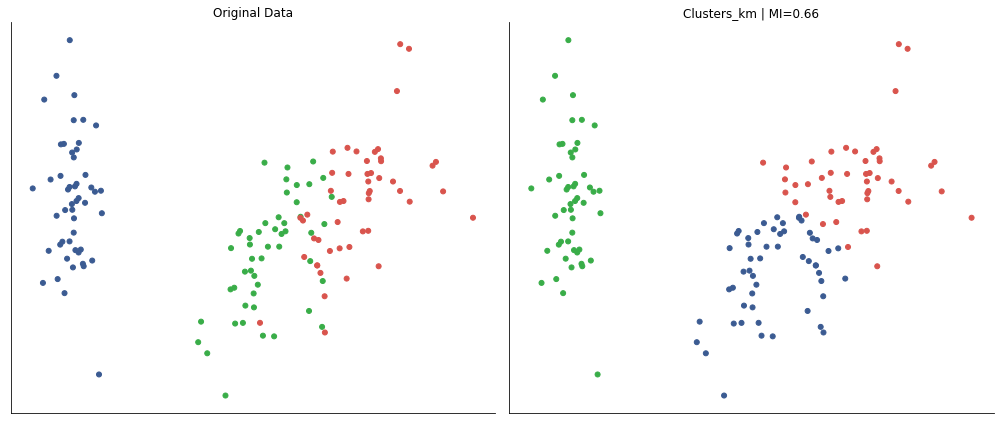

In [15]:
clusterer_km = KMeans(n_clusters=3)
data['clusters_km'] = clusterer_km.fit_predict(features_standardized)
print(data['clusters_km'].value_counts())
fig, axes = plt.subplots(ncols=2, 
                         figsize=(14, 6))

labels, clusters_km = data.label, data.clusters_km
mi = adjusted_mutual_info_score(labels, clusters_km)# mide lo que se parecen las dos columnas
# labels son los tipos de flor y clusters los obtenidos por el método DBSCAN

axes[0].scatter(*features_2D.T, c=data.label, s=25, cmap=cmap)
axes[0].set_title('Original Data')
axes[1].scatter(*features_2D.T, c=data.clusters_km, s=25, cmap=cmap)
# axes[1].set_title('Clustering data')
axes[1].set_title('Clusters_km | MI={:.2f}'.format(mi))

for ax in axes:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
sns.despine()
fig.tight_layout()

# Otro Ejemplo

In [16]:
# get the dataset
X = pd.read_csv('CC GENERAL.csv')
X.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


# Prepare the data

In [18]:
X.isna().sum() , X.shape

(CUST_ID                               0
 BALANCE                               0
 BALANCE_FREQUENCY                     0
 PURCHASES                             0
 ONEOFF_PURCHASES                      0
 INSTALLMENTS_PURCHASES                0
 CASH_ADVANCE                          0
 PURCHASES_FREQUENCY                   0
 ONEOFF_PURCHASES_FREQUENCY            0
 PURCHASES_INSTALLMENTS_FREQUENCY      0
 CASH_ADVANCE_FREQUENCY                0
 CASH_ADVANCE_TRX                      0
 PURCHASES_TRX                         0
 CREDIT_LIMIT                          1
 PAYMENTS                              0
 MINIMUM_PAYMENTS                    313
 PRC_FULL_PAYMENT                      0
 TENURE                                0
 dtype: int64,
 (8950, 18))

In [19]:
X.dropna(axis = 0, inplace = True)

In [20]:
X.isna().sum(), X.shape

(CUST_ID                             0
 BALANCE                             0
 BALANCE_FREQUENCY                   0
 PURCHASES                           0
 ONEOFF_PURCHASES                    0
 INSTALLMENTS_PURCHASES              0
 CASH_ADVANCE                        0
 PURCHASES_FREQUENCY                 0
 ONEOFF_PURCHASES_FREQUENCY          0
 PURCHASES_INSTALLMENTS_FREQUENCY    0
 CASH_ADVANCE_FREQUENCY              0
 CASH_ADVANCE_TRX                    0
 PURCHASES_TRX                       0
 CREDIT_LIMIT                        0
 PAYMENTS                            0
 MINIMUM_PAYMENTS                    0
 PRC_FULL_PAYMENT                    0
 TENURE                              0
 dtype: int64,
 (8636, 18))

In [21]:
X = X.drop(columns = 'CUST_ID')

In [22]:
X.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.00,0,12,7500.0,622.066742,627.284787,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.00,0,1,1200.0,678.334763,244.791237,0.000000,12
5,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.00,0,8,1800.0,1400.057770,2407.246035,0.000000,12


# PCA

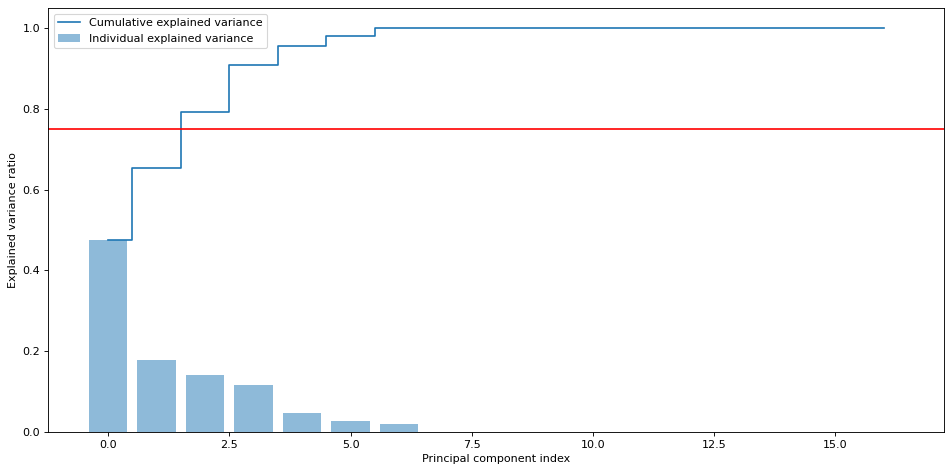

In [23]:
scaler = StandardScaler()
features_standardized = scaler.fit_transform(X)
n = len(X)
pca = PCA()
pca.fit(X)
exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

threshold = 0.75
plt.figure(figsize=(12, 6), dpi=80)
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.axhline(y=threshold, color='r', linestyle='-')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

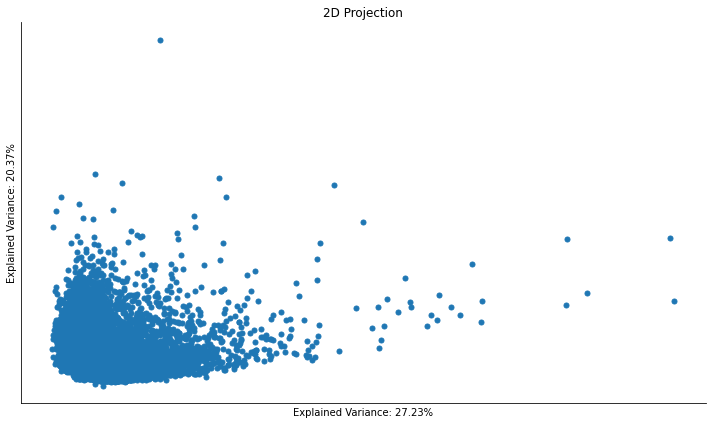

In [24]:
pca = PCA(n_components=2)
features_2D = pca.fit_transform(features_standardized)
ev1, ev2 = pca.explained_variance_ratio_
ax = plt.figure(figsize=(10, 6)).gca(title='2D Projection', 
                      xlabel=f'Explained Variance: {ev1:.2%}', 
                      ylabel=f'Explained Variance: {ev2:.2%}')
ax.scatter(*features_2D.T,  s=25, cmap=cmap)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_yticks([])
sns.despine()
plt.tight_layout();

# K means clustering

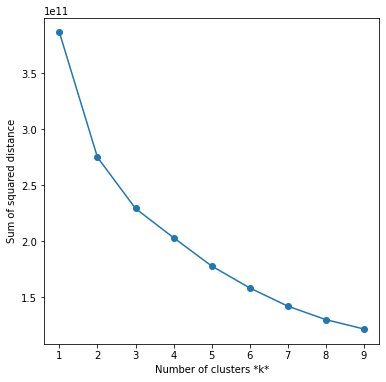

In [25]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [26]:
# call the model and fit it on training data
k_clf = KMeans(n_clusters = 4, random_state = 0)
k_clf.fit(X)
pd_final_cluster = pd.DataFrame(k_clf.predict(X), index=X.index)
pd_final_cluster.columns = ['cluster']
pd_data = pd.concat([pd_final_cluster, X],axis=1)
pd_data[pd_data['cluster']==1].describe()

,cluster,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,5440.0,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000
mean,1.0,839.084236,0.875516,537.917853,264.811706,273.405597,497.927529,0.459965,0.137340,0.352313,0.111772,2.345588,9.965074,2283.793607,956.909709,604.257656,0.154835,11.413971
std,0.0,850.231630,0.222807,747.654631,551.388086,453.904290,897.822308,0.393896,0.235888,0.391567,0.169621,4.768290,13.638447,1164.420690,1034.448887,1555.751050,0.288966,1.461886
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.049513,0.019163,0.000000,6.000000
25%,1.0,87.276679,0.833333,18.320000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1200.000000,309.330050,153.671089,0.000000,12.000000
50%,1.0,617.798440,1.000000,266.680000,0.000000,72.420000,0.000000,0.416667,0.000000,0.166667,0.000000,0.000000,6.000000,2000.000000,587.487406,239.207383,0.000000,12.000000
75%,1.0,1325.504261,1.000000,718.770000,279.257500,374.842500,681.663200,0.909091,0.166667,0.750000,0.166667,3.000000,12.000000,3000.000000,1219.587781,529.592766,0.166667,12.000000
max,1.0,4380.251712,1.000000,8591.310000,8008.500000,4249.920000,6718.127621,1.000000,1.000000,1.000000,1.166667,123.000000,186.000000,5700.000000,10893.778440,28483.254830,1.000000,12.000000


In [27]:
pd_data[pd_data['cluster']==2].describe()

,cluster,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,25.0,25.000000,25.000000,25.00000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.00
mean,2.0,5519.044818,0.959636,26256.86280,21002.018800,5254.844000,1491.964501,0.912667,0.808667,0.732000,0.060000,2.440000,123.320000,16160.000000,28433.712926,3222.003800,0.497424,11.92
std,0.0,4265.107716,0.148780,9829.92911,9530.796328,4710.385756,4790.236230,0.219811,0.290160,0.370026,0.162304,7.789309,89.027018,5467.174773,9274.404546,4910.967849,0.403136,0.40
min,2.0,1268.809031,0.272727,1788.84000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,3.000000,7500.000000,13002.303930,410.800069,0.000000,10.00
25%,2.0,2774.249582,1.000000,21802.60000,15158.900000,1043.430000,0.000000,1.000000,0.666667,0.583333,0.000000,0.000000,70.000000,12000.000000,22542.587050,569.401398,0.083333,12.00
50%,2.0,3454.094319,1.000000,25615.07000,20646.070000,4732.290000,0.000000,1.000000,1.000000,0.916667,0.000000,0.000000,101.000000,17000.000000,26652.344320,1193.031030,0.416667,12.00
75%,2.0,8151.985277,1.000000,31299.35000,25122.770000,7740.270000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,157.000000,18000.000000,33994.727850,2746.592199,0.916667,12.00
max,2.0,19043.138560,1.000000,49039.57000,40761.250000,15497.190000,19513.474830,1.000000,1.000000,1.000000,0.666667,35.000000,358.000000,30000.000000,50721.483360,18621.013310,1.000000,12.00


In [28]:
k_clf.labels_

array([1, 0, 0, ..., 1, 1, 1], dtype=int32)

In [29]:
pd_data['cluster'].value_counts()

1    5440
0    2517
3     654
2      25
Name: cluster, dtype: int64

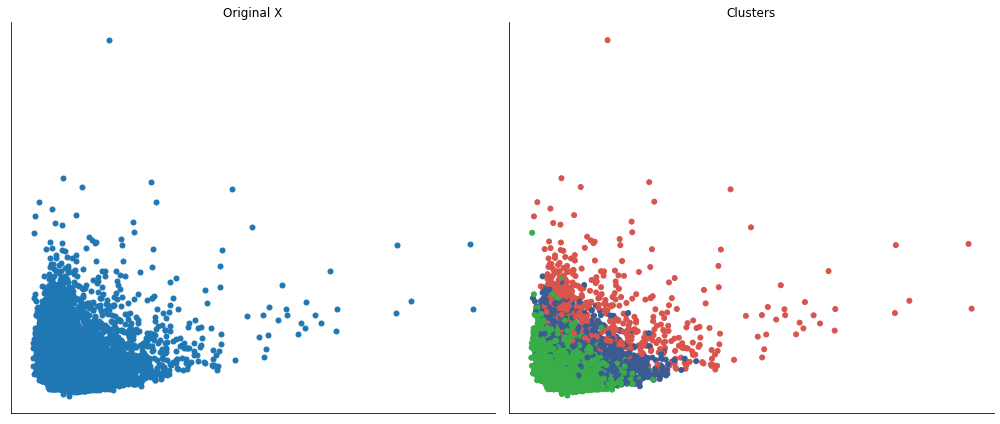

In [30]:
fig, axes = plt.subplots(ncols=2, 
                         figsize=(14, 6))

clusters = pd_data['cluster']


axes[0].scatter(*features_2D.T, s=25, cmap=cmap)
axes[0].set_title('Original X')
axes[1].scatter(*features_2D.T, c=clusters, s=25, cmap=cmap)
# axes[1].set_title('Clustering X')
axes[1].set_title('Clusters')

for ax in axes:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
sns.despine()
fig.tight_layout()

# DBSCAN clustering algorithm

In [31]:
clusterer = DBSCAN(eps=0.05, min_samples=5) # los parámetros del algoritmo por defecto son:


X['clusters_db'] = clusterer.fit_predict(features_standardized)
print(X['clusters_db'].value_counts())

-1    8597
 1      19
 0      14
 2       6
Name: clusters_db, dtype: int64


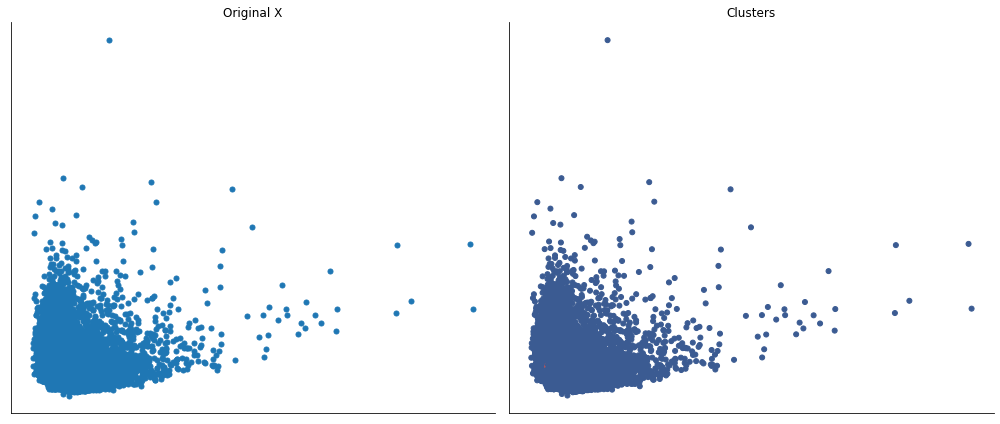

In [32]:
fig, axes = plt.subplots(ncols=2, 
                         figsize=(14, 6))

clusters_db = X.clusters_db


axes[0].scatter(*features_2D.T, s=25, cmap=cmap)
axes[0].set_title('Original X')
axes[1].scatter(*features_2D.T, c=clusters_db, s=25, cmap=cmap)
# axes[1].set_title('Clustering X')
axes[1].set_title('Clusters')

for ax in axes:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
sns.despine()
fig.tight_layout()